<a href="https://colab.research.google.com/github/urbanik/DP/blob/main/raindrop%26insect_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Similar work - https://github.com/GTC7788/raindropDetection

https://github.com/tobybreckon/raindrop-detection-cnn

Imports

In [ ]:
import torch, torchvision
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from torchsummary import summary

import numpy as np
from skimage import io
import pandas as pd
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time

# **Dataset**
Data transformation - different sizes of input pictures of adherent raindrops and insect

Creating batches of different sizes 
https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278

Custom dataset 
https://www.youtube.com/watch?v=ZoZHd0Zm3RY
Custam dataset on Google Colab
https://www.youtube.com/watch?v=b4R9WvfHs4M


Resizing
https://discuss.pytorch.org/t/does-resize-affect-image-details/86503




In [ ]:
#ARAI - Adherent Raindrops And Insect
class ARAI_dataset(Dataset):
  def __init__(self, csv_file, root_dir, transform = None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      img_PIL = transforms.ToPILImage()(image)
      img_PIL = transforms.Resize([100, 100])(img_PIL)
      img = self.transform(img_PIL)
      
    
    return img, y_label

In [ ]:
dataset = ARAI_dataset(csv_file='ARAI/ARAI_labels.csv', root_dir='ARAI/images', transform=transforms.ToTensor())
len(dataset)
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [950, 200, 10])

train_data_size = len(train_set)
valid_data_size = len(valid_set)

# Get a mapping of the indices to the class names, in order to see the output classes of the test images. -NOT WOKING YET
#idx_to_class = {v: k for k, v in train_set.class_to_idx.items()}
#print(idx_to_class)

# loaders
batch_size = 32
train_data_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)


tensor(1)


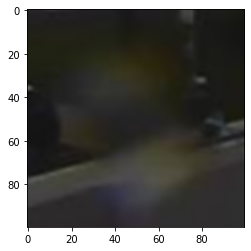

In [ ]:
example = test_set[2]
print(example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

ALEXNET
https://www.youtube.com/watch?v=8etkVC93yU4

In [ ]:
AlexNet = models.alexnet(pretrained=True)
AlexNet#freezing parameters
for param in AlexNet.parameters():
  param.requires_grad = False


TRANSFER LEARNING

The basic premise of transfer learning is simple: take a model trained on a large dataset and transfer its knowledge to a smaller dataset. For object recognition with a CNN, we freeze the early convolutional layers of the network and only train the last few layers which make a prediction.

https://machinelearningmastery.com/transfer-learning-for-deep-learning/

Example of implementation -
https://www.youtube.com/watch?v=8etkVC93yU4

Github - https://github.com/madsendennis/notebooks/blob/master/pytorch/3_PyTorch_Transfer_learning.ipynb 

In [ ]:
#freezing parameters - TRANSFERLEARNING
for param in AlexNet.parameters():
  param.requires_grad = False


In [ ]:
#change of the final layer of AlexNet model 
AlexNet.classifier[6] = nn.Linear(4096, 3) # we have 2 classes already
AlexNet.classifier.add_module("7", nn.LogSoftmax(dim=1))
AlexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#summary(AlexNet, (2, 80, 80))

Loss function
NLLLoss - https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html


In [1]:
loss_func = nn.NLLLoss()
loos_func

NameError: ignored

Optimizer

In [ ]:
optimizer = optim.Adam(AlexNet.parameters())
optimizer

Train and validate function

In [ ]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
  start = time.time()
  history = []
  best_acc = 0.0
  for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    model.train()

    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    for i, (inputs, labels) in enumerate(train_data_loader):

      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # clean existing gradients

      # Forward pass - compute outputs on input data using the model
      outputs = model(inputs)
      
      # Compute loss
      loss = loss_criterion(outputs, labels)
      
      # Backpropagate the gradients
      loss.backward()
      
      # Update the parameters
      optimizer.step()
      
      # Compute the total loss for the batch and add it to train_loss
      train_loss += loss.item() * inputs.size(0)
      
      # Compute the accuracy
      ret, predictions = torch.max(outputs.data, 1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))
      
      # Convert correct_counts to float and then compute the mean
      acc = torch.mean(correct_counts.type(torch.FloatTensor))
      
      # Compute total accuracy in the whole batch and add to train_acc
      train_acc += acc.item() * inputs.size(0)
    # Validation - No gradient tracking needed
    with torch.no_grad():

      # Set to evaluation mode
      model.eval()

      # Validation loop
      for j, (inputs, labels) in enumerate(valid_data_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)

          # Forward pass - compute outputs on input data using the model
          outputs = model(inputs)

          # Compute loss
          loss = loss_criterion(outputs, labels)

          # Compute the total loss for the batch and add it to valid_loss
          valid_loss += loss.item() * inputs.size(0)

          # Calculate validation accuracy
          ret, predictions = torch.max(outputs.data, 1)
          correct_counts = predictions.eq(labels.data.view_as(predictions))

          # Convert correct_counts to float and then compute the mean
          acc = torch.mean(correct_counts.type(torch.FloatTensor))

          # Compute total accuracy in the whole batch and add to valid_acc
          valid_acc += acc.item() * inputs.size(0)

          #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
      
    # Find average training loss and training accuracy
    avg_train_loss = train_loss/train_data_size 
    avg_train_acc = train_acc/train_data_size

    # Find average training loss and training accuracy
    avg_valid_loss = valid_loss/valid_data_size 
    avg_valid_acc = valid_acc/valid_data_size

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
            
    epoch_end = time.time()

    print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
    
    # Save if the model has best accuracy till now
    #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
          
  return model, history      

Train and validation into graph

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 100
trained_model, history = train_and_validate(AlexNet, loss_func, optimizer, num_epochs)

#torch.save(history, dataset+'_history.pt')

Epoch: 1/100
Epoch : 001, Training: Loss: 0.5062, Accuracy: 76.0000%, 
		Validation : Loss : 0.3726, Accuracy: 86.5000%, Time: 8.9535s
Epoch: 2/100
Epoch : 002, Training: Loss: 0.3623, Accuracy: 83.2632%, 
		Validation : Loss : 0.3626, Accuracy: 83.5000%, Time: 9.7299s
Epoch: 3/100
Epoch : 003, Training: Loss: 0.3288, Accuracy: 85.0526%, 
		Validation : Loss : 0.3278, Accuracy: 87.5000%, Time: 11.0150s
Epoch: 4/100
Epoch : 004, Training: Loss: 0.2837, Accuracy: 87.8947%, 
		Validation : Loss : 0.3205, Accuracy: 86.5000%, Time: 10.9916s
Epoch: 5/100
Epoch : 005, Training: Loss: 0.2688, Accuracy: 87.5789%, 
		Validation : Loss : 0.3083, Accuracy: 87.5000%, Time: 11.2762s
Epoch: 6/100
Epoch : 006, Training: Loss: 0.2577, Accuracy: 88.6316%, 
		Validation : Loss : 0.3390, Accuracy: 85.5000%, Time: 11.7667s
Epoch: 7/100
Epoch : 007, Training: Loss: 0.2653, Accuracy: 88.1053%, 
		Validation : Loss : 0.3031, Accuracy: 86.5000%, Time: 11.0040s
Epoch: 8/100
Epoch : 008, Training: Loss: 0.2432, 

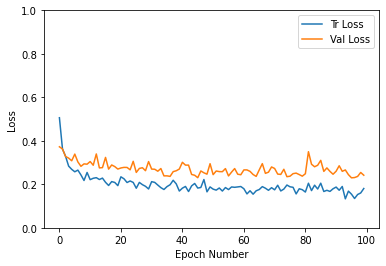

In [ ]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig('loss_curve.png')
plt.show()

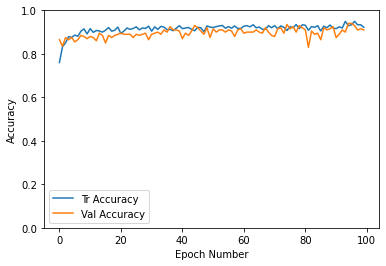

In [ ]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('accuracy_curve.png')
plt.show()

Prediction function


In [ ]:
def predict(model, image):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    img_PIL = transforms.ToPILImage()(image)
    img_PIL = transforms.Resize([100, 100])(img_PIL)
    test_image_tensor = transforms.ToTensor()(img_PIL)
    test_image_tensor = test_image_tensor.view(1, 3, 100, 100)
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Predcition", i+1, ":", topclass.numpy()[0][i], ", Score: ", topk.numpy()[0][i]) #idx_to_class[topclass.numpy()[0][i]]

Test on test data

Predcition 1 : 1 , Score:  0.9227908
Predcition 2 : 2 , Score:  0.07720834
Predcition 3 : 0 , Score:  7.645928e-07
Actual: tensor(1)


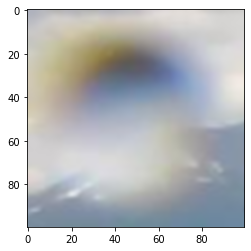

In [ ]:
example = test_set[0]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.99828917
Predcition 2 : 2 , Score:  0.0017104303
Predcition 3 : 0 , Score:  3.4750423e-07
Actual: tensor(1)


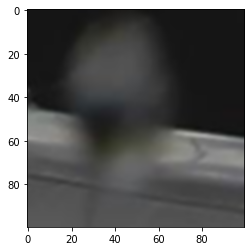

In [ ]:
example = test_set[1]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.99998236
Predcition 2 : 2 , Score:  1.7600114e-05
Predcition 3 : 0 , Score:  2.7345422e-08
Actual: tensor(1)


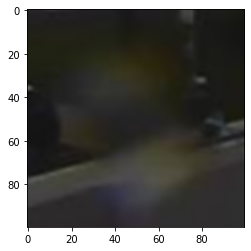

In [ ]:
example = test_set[2]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 2 , Score:  0.99999976
Predcition 2 : 1 , Score:  2.393533e-07
Predcition 3 : 0 , Score:  3.2359844e-12
Actual: tensor(2)


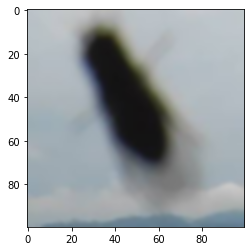

In [ ]:
example = test_set[3]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.99954104
Predcition 2 : 2 , Score:  0.00045858842
Predcition 3 : 0 , Score:  3.0735478e-07
Actual: tensor(1)


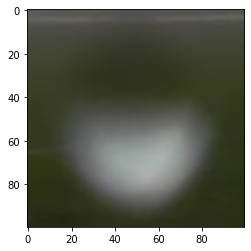

In [ ]:
example = test_set[4]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.99963665
Predcition 2 : 2 , Score:  0.00036325573
Predcition 3 : 0 , Score:  8.048496e-08
Actual: tensor(1)


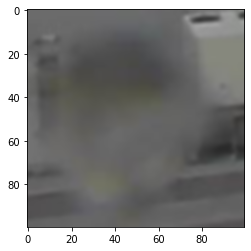

In [ ]:
example = test_set[5]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.94195217
Predcition 2 : 2 , Score:  0.05804423
Predcition 3 : 0 , Score:  3.5721423e-06
Actual: tensor(1)


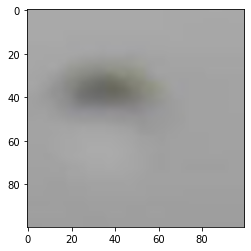

In [ ]:
example = test_set[6]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.99737465
Predcition 2 : 2 , Score:  0.0026232952
Predcition 3 : 0 , Score:  2.080471e-06
Actual: tensor(1)


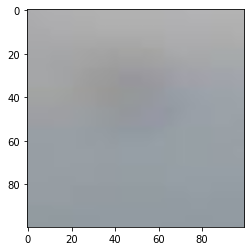

In [ ]:
example = test_set[7]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.9766961
Predcition 2 : 2 , Score:  0.023300285
Predcition 3 : 0 , Score:  3.6342376e-06
Actual: tensor(1)


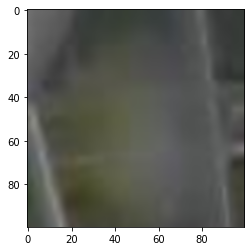

In [ ]:
example = test_set[8]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : 1 , Score:  0.5525609
Predcition 2 : 2 , Score:  0.44742298
Predcition 3 : 0 , Score:  1.6144568e-05
Actual: tensor(2)


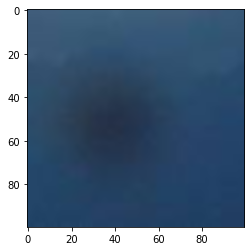

In [ ]:
example = test_set[9]
predict(trained_model, example[0])
print("Actual:", example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")